In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from datetime import datetime, timedelta
import scipy.stats
from scipy import stats

Calling in the Formaldyhe values at all locations

In [4]:
HU_HCHOs_filepath = "../HULL/Data/Pandora156s1_HU_L2_HCHOs.txt"
CBBT_HCHOs_filepath = "../HULL/Data/Pandora255s1_VirginiaBeachVA-CBBT_L2_HCHOs.txt"
LaRC_HCHOs_filepath = "../HULL/Data/Pandora37s1_HamptonVA_L2_HCHOs.txt"

col_names_HCHOs = ["DateTime", "Time since 2000", "Duration of Measurement", "Solar Zenith", "Solar Azimuth", "Lunar Zenith", "Lunar Azimuth", "rms", "normalized rms", "Expected rms",
                   "expected normalized rms", "Climatological station pressure", "data processing type", "calibration file version", "calibration file validity starting date", "mean value of measured data", "wavelength effective temperature", "est avg residual stray light level", "retrieved wavelength shift from L1", "retrieved total avelength shift",
                   "retrieved resolution change", "integration time", "number of bright count cycles", "effective position of filterwheel #1", "effective position of filterwheel #2", "atmospheric variability", "Estimated AOD at starting wavelength", "Estimated AOD at center wavelength", "Estimated aerosol optical depth at ending wavelength", "L1 quality flag",
                   "Sum over 2^i using those i L1 exceeds the DQ1 limit", "Sum over 2^i using those i L1 exceeds the DQ2 limit", "L2Fit quality flag", "Sum over 2^i using those i L2Fit exceeds the DQ1 limit", "Sum over 2^i using those i L2Fit exceeds the DQ2 limit", "L2 quality flag", "Sum over 2^i using those i L2 exceeds the DQ1 limit", "Sum over 2^i using those i L2 exceeds the DQ2 limit", "HCHO total vertical column amount", "Independent uncertainty of HCHO TC",
                   "Structured uncertainty of HCHO TC", "Common uncertainty of HCHO TC", "total uncertainty of HCHO TC", "rms-based uncertainty of HCHO TC", "HCHO effective temperature", "Independent undertainty of HCHO eff temp", "structured uncertainty of HCHO eff temp", "common uncertainty of HCHO eff temp", "Total uncertainty of HCHO eff temp", "Direct HCHO Air Mass Factor", 
                   "Uncertainty of direct HCHO AMF", "Diffuse correction"]

HU_HCHOs_df=pd.read_csv(HU_HCHOs_filepath, sep = " ",encoding='latin',on_bad_lines='warn', skiprows=75, names=col_names_HCHOs)
CBBT_HCHOs_df=pd.read_csv(CBBT_HCHOs_filepath, sep = " ",encoding='latin',on_bad_lines='warn', skiprows=75, names=col_names_HCHOs)
LaRC_HCHOs_df=pd.read_csv(LaRC_HCHOs_filepath, sep = " ",encoding='latin',on_bad_lines='warn', skiprows=75, names=col_names_HCHOs) 


Selects just the date range of interest

In [5]:
# Define J2000 epoch (January 1, 2000 at 12:00 UTC)
j2000_epoch = datetime(2000, 1, 1, 0, 0)

begin_target_date = datetime(2024, 7, 1, 0, 0) # (year, month, day, 24hr, min)
end_target_date = datetime(2024, 7, 31, 0, 0) # (year, month, day, 24hr, min)


# Compute fractional days since J2000
begin_delta_days = (begin_target_date - j2000_epoch).total_seconds() / 86400
end_delta_days = (end_target_date - j2000_epoch).total_seconds() / 86400

delta_days = [begin_delta_days, end_delta_days]

print(delta_days) 

[8948.0, 8978.0]


In [7]:
# Makes df for just dates of interest


HU_df_doi = HU_HCHOs_df[(HU_HCHOs_df.iloc[:, col_names_HCHOs.index("Time since 2000")].values > delta_days[0])&(HU_HCHOs_df.iloc[:, col_names_HCHOs.index("Time since 2000")].values < delta_days[1])]
CBBT_df_doi = CBBT_HCHOs_df[(CBBT_HCHOs_df.iloc[:, col_names_HCHOs.index("Time since 2000")].values > delta_days[0])&(CBBT_HCHOs_df.iloc[:, col_names_HCHOs.index("Time since 2000")].values < delta_days[1])]

#Langley has been commented out due to it's dates not falling in range
#LaRC_df_doi = LaRC_HCHOs_df[(LaRC_HCHOs_df.iloc[:, col_names_HCHOs.index("Time since 2000")].values > delta_days[0])&(LaRC_HCHOs_df.iloc[:, col_names_HCHOs.index("Time since 2000")].values < delta_days[1])]

# Sanity check to make sure there is data
print(len(HU_df_doi))
print(len(CBBT_df_doi))

1764
2403


0.2598294527442551


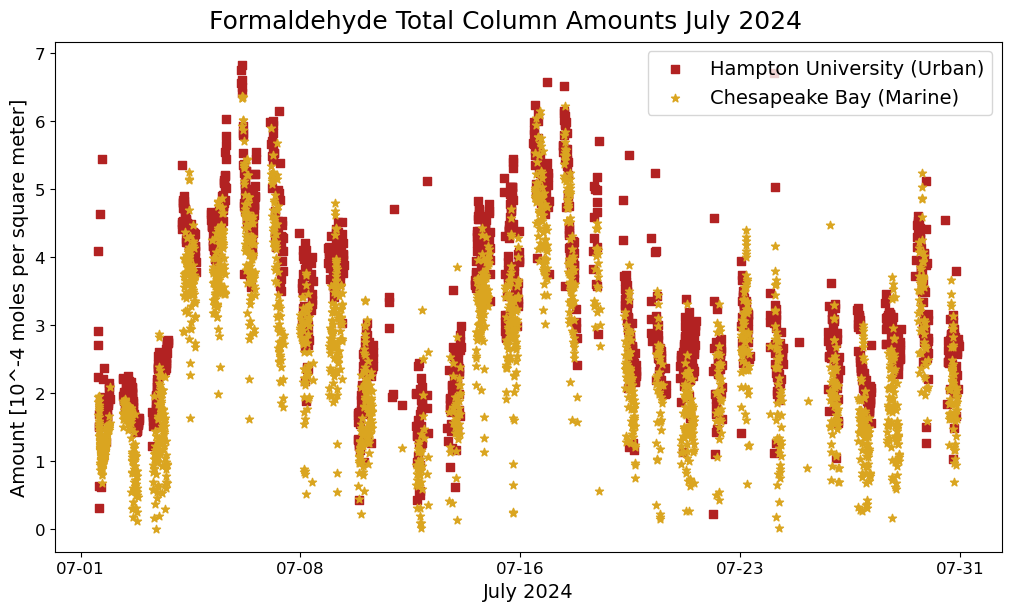

In [8]:
# Call in specific values by location
HU_time = HU_df_doi.iloc[:, [col_names_HCHOs.index("Time since 2000")]].values
HU_amount = HU_df_doi.iloc[:, [col_names_HCHOs.index("HCHO total vertical column amount")]].values
CBBT_time = CBBT_df_doi.iloc[:, [col_names_HCHOs.index("Time since 2000")]].values
CBBT_amount = CBBT_df_doi.iloc[:, [col_names_HCHOs.index("HCHO total vertical column amount")]].values

# Removes the error codes and replaces them with NaN
HU_amount[HU_amount == -9*10**99] = np.nan
CBBT_amount[CBBT_amount == -9*10**99] = np.nan

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

# Convert to pandas series for quantile function
HU_time = pd.Series(HU_time.flatten())
HU_amount = pd.Series(HU_amount.flatten())
CBBT_time = pd.Series(CBBT_time.flatten())
CBBT_amount = pd.Series(CBBT_amount.flatten())

# This is to rule out outliers by the IQR method
HU_Q1_amount = HU_amount.quantile(0.25)
HU_Q3_amount = HU_amount.quantile(0.75)
HU_IQR_amount = HU_Q3_amount - HU_Q1_amount
CBBT_Q1_amount = CBBT_amount.quantile(0.25)
CBBT_Q3_amount = CBBT_amount.quantile(0.75)
CBBT_IQR_amount = CBBT_Q3_amount - CBBT_Q1_amount

# Create a mask to filter out outliers
HU_mask = (
    (HU_amount >= HU_Q1_amount - 1.5 * HU_IQR_amount) & (HU_amount <= HU_Q3_amount + 1.5 * HU_IQR_amount) & (HU_amount >0))
CBBT_mask = (
    (CBBT_amount >= CBBT_Q1_amount - 1.5 * CBBT_IQR_amount) & (CBBT_amount <= CBBT_Q3_amount + 1.5 * CBBT_IQR_amount) & (CBBT_amount >0))

# Filter the data
HU_time_filtered = HU_time[HU_mask]
HU_amount_filtered = HU_amount[HU_mask]
CBBT_time_filtered = CBBT_time[CBBT_mask]
CBBT_amount_filtered = CBBT_amount[CBBT_mask]

#finished with the IQR filtering

date=[]
HU_mean=[]
CBBT_mean=[]
# for each day, find the mean
for i in range(int(delta_days[0]), int(delta_days[1])-1):
    avg = np.nanmean(HU_amount_filtered[(HU_time >= i)&(HU_time < i+1)])
    HU_mean.append(avg)
    avg = np.nanmean(CBBT_amount_filtered[(CBBT_time >= i)&(CBBT_time < i+1)])
    CBBT_mean.append(avg)
    date.append(i)
    

# Plot data
ax.scatter(HU_time_filtered, HU_amount_filtered/10**-4, marker='s', color = 'firebrick', label = "Hampton University (Urban)")
ax.scatter(CBBT_time_filtered, CBBT_amount_filtered/10**-4, marker='*', color = 'goldenrod', label = 'Chesapeake Bay (Marine)')

# Labels and title
ax.set_xlabel('July 2024', size = 14)
ax.set_ylabel('Amount [10^-4 moles per square meter]', size = 14)
fig.suptitle('Formaldehyde Total Column Amounts July 2024', size = 18)
ax.set_xticks(np.linspace(np.nanmin(delta_days[0]), np.nanmax(delta_days[1]), 5))
ax.set_xticklabels(pd.to_datetime(np.linspace(np.nanmin(delta_days[0]), np.nanmax(delta_days[1]), 5) * 86400 + 946684800, unit="s", utc=True).strftime('%m-%d'), size = 12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize = 14)

# Show plot
plt.show()
#plt.savefig('HCHO_TC_July2024.jpg', dpi=300, bbox_inches='tight')